In [1]:
import csv
import cv2
import numpy as np

lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []
#lines = lines.pop(0)
for line in lines[1:]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = './data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

X_train = np.array(images)
y_train = np.array(measurements)

In [2]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


Using TensorFlow backend.


In [3]:
lines[0][-1]
#source_path
#current_path

'speed'

First try

In [13]:
model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7)
model.save('model1.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/7
6428/6428 [==============================] - 8s - loss: 4875480.5198 - val_loss: 4428.1938
Epoch 2/7
6428/6428 [==============================] - 8s - loss: 3660.6958 - val_loss: 2625.8169
Epoch 3/7
6428/6428 [==============================] - 8s - loss: 2554.7666 - val_loss: 2227.6700
Epoch 4/7
6428/6428 [==============================] - 8s - loss: 2123.7398 - val_loss: 1769.2834
Epoch 5/7
6428/6428 [==============================] - 8s - loss: 2385.1122 - val_loss: 3042.1658
Epoch 6/7
6428/6428 [==============================] - 8s - loss: 2536.4234 - val_loss: 1878.7871
Epoch 7/7
6428/6428 [==============================] - 8s - loss: 4045.2438 - val_loss: 6724.5042


## Second try: lambda layers
In Keras, lambda layers can be used to create arbitrary functions that operate on each image as it passes through the layer.

In this project, a lambda layer is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will normalize input images when making predictions in drive.py.

That lambda layer could take each pixel in an image and run it through the formulas:

pixel_normalized = pixel / 255

pixel_mean_centered = pixel_normalized - 0.5

A lambda layer will look something like:

Lambda(lambda x: (x / 255.0) - 0.5)

In [14]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)
model.save('model2.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/2
6428/6428 [==============================] - 8s - loss: 2.2740 - val_loss: 1.8223
Epoch 2/2
6428/6428 [==============================] - 8s - loss: 3.7297 - val_loss: 3.5815


Use epoch=7, makes the model loss go up and down. So it could be overfitting, so reduce to 2.

## LeNet

In [16]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model3.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/5
6428/6428 [==============================] - 26s - loss: 1.7542 - val_loss: 0.0170
Epoch 2/5
6428/6428 [==============================] - 24s - loss: 0.0143 - val_loss: 0.0147
Epoch 3/5
6428/6428 [==============================] - 24s - loss: 0.0125 - val_loss: 0.0144
Epoch 4/5
6428/6428 [==============================] - 24s - loss: 0.0114 - val_loss: 0.0135
Epoch 5/5
6428/6428 [==============================] - 24s - loss: 0.0106 - val_loss: 0.0124


## Data Augmentation
Problem is the car like to steering to the left, since it's a loop.

Flipping Images And Steering Measurements
A effective technique for helping with the left turn bias involves flipping images and taking the opposite sign of the steering measurement. For example:

import numpy as np
image_flipped = np.fliplr(image)
measurement_flipped = -measurement
The cv2 library also has similar functionality with the flip method.

In [17]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(images)
y_train = np.array(measurements)

In [18]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model4.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/5
6428/6428 [==============================] - 25s - loss: 0.0113 - val_loss: 0.0121
Epoch 2/5
6428/6428 [==============================] - 25s - loss: 0.0079 - val_loss: 0.0126
Epoch 3/5
6428/6428 [==============================] - 25s - loss: 0.0059 - val_loss: 0.0133
Epoch 4/5
6428/6428 [==============================] - 25s - loss: 0.0048 - val_loss: 0.0138
Epoch 5/5
6428/6428 [==============================] - 25s - loss: 0.0035 - val_loss: 0.0154


## Using Multiple Cameras
The simulator captures images from three cameras mounted on the car: a center, right and left camera. That’s because of the issue of recovering from being off-center.

In the simulator, you can weave all over the road and turn recording on and off to record recovery driving. In a real car, however, that’s not really possible. At least not legally.

So in a real car, we’ll have multiple cameras on the vehicle, and we’ll map recovery paths from each camera. For example, if you train the model to associate a given image from the center camera with a left turn, then you could also train the model to associate the corresponding image from the left camera with a somewhat softer left turn. And you could train the model to associate the corresponding image from the right camera with an even harder left turn.

In that way, you can simulate your vehicle being in different positions, somewhat further off the center line. To read more about this approach, see [this paper](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) by our friends at NVIDIA that makes use of this technique.

### Explanation of How Multiple Cameras Work
The image below gives a sense for how multiple cameras are used to train a self-driving car. This image shows a bird's-eye perspective of the car. The driver is moving forward but wants to turn towards a destination on the left.

From the perspective of the left camera, the steering angle would be less than the steering angle from the center camera. From the right camera's perspective, the steering angle would be larger than the angle from the center camera. The next section will discuss how this can be implemented in your project although there is no requirement to use the left and right camera images.

!()[https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/46a70500-493e-4057-a78e-b3075933709d/concepts/2cd424ad-a661-4754-8421-aec8cb018005#]

### Multiple Cameras in This Project
For this project, recording recoveries from the sides of the road back to center is effective. But it is also possible to use all three camera images to train the model. When recording, the simulator will simultaneously save an image for the left, center and right cameras. Each row of the csv log file, driving_log.csv, contains the file path for each camera as well as information about the steering measurement, throttle, brake and speed of the vehicle.
Here is some example code to give an idea of how all three images can be used:

In [6]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
images = []
measurements = []        
for row in lines[1:]:
    steering_center = float(row[3])
    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = "./data/IMG/" # fill in the path to your training IMG directory
    img_center = cv2.imread(path + row[0].split('/')[-1])
    img_left   = cv2.imread(path + row[1].split('/')[-1])
    img_right  = cv2.imread(path + row[2].split('/')[-1])

    # add images and angles to data set
    images.append(img_center)
    images.append(img_left)
    images.append(img_right)
    measurements.append(steering_center)
    measurements.append(steering_left)
    measurements.append(steering_right)

    
X_train = np.array(images)
y_train = np.array(measurements)

During training, you want to feed the left and right camera images to your model as if they were coming from the center camera. This way, you can teach your model how to steer if the car drifts off to the left or the right.

Figuring out how much to add or subtract from the center angle will involve some experimentation.

During prediction (i.e. "autonomous mode"), you only need to predict with the center camera image.

It is not necessary to use the left and right images to derive a successful model. Recording recovery driving from the sides of the road is also effective.

In [7]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(84))
model.add(Dense(1))

Train on 19286 samples, validate on 4822 samples
Epoch 1/5
19286/19286 [==============================] - 80s - loss: 0.5049 - val_loss: 0.0155
Epoch 2/5
19286/19286 [==============================] - 76s - loss: 0.0107 - val_loss: 0.0121
Epoch 3/5
19286/19286 [==============================] - 76s - loss: 0.0090 - val_loss: 0.0117
Epoch 4/5
19286/19286 [==============================] - 76s - loss: 0.0082 - val_loss: 0.0114
Epoch 5/5
19286/19286 [==============================] - 76s - loss: 0.0076 - val_loss: 0.0123


In [ ]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model5.h5')

## Cropping Images in Keras
The cameras in the simulator capture 160 pixel by 320 pixel images.

Not all of these pixels contain useful information, however. In the image above, the top portion of the image captures trees and hills and sky, and the bottom portion of the image captures the hood of the car.

Your model might train faster if you crop each image to focus on only the portion of the image that is useful for predicting a steering angle.
Cropping2D Layer
Keras provides the Cropping2D layer for image cropping within the model. This is relatively fast, because the model is parallelized on the GPU, so many images are cropped simultaneously.

By contrast, image cropping outside the model on the CPU is relatively slow.

Also, by adding the cropping layer, the model will automatically crop the input images when making predictions in drive.py.

The Cropping2D layer might be useful for choosing an area of interest that excludes the sky and/or the hood of the car.

Here is an example of an input image and its cropped version after passing through a Cropping2D layer:

In [13]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(84))
model.add(Dense(1))

In [14]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model6.h5')

Train on 19286 samples, validate on 4822 samples
Epoch 1/5
19286/19286 [==============================] - 42s - loss: 0.0295 - val_loss: 0.0211
Epoch 2/5
19286/19286 [==============================] - 42s - loss: 0.0161 - val_loss: 0.0247
Epoch 3/5
19286/19286 [==============================] - 42s - loss: 0.0144 - val_loss: 0.0204
Epoch 4/5
19286/19286 [==============================] - 42s - loss: 0.0136 - val_loss: 0.0187
Epoch 5/5
19286/19286 [==============================] - 42s - loss: 0.0130 - val_loss: 0.0214


## NVIDIA Architecture

https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

In [15]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(54,3,3,activation="relu"))
model.add(Convolution2D(54,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

In [20]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model7.h5')

Train on 19286 samples, validate on 4822 samples
Epoch 1/5
19286/19286 [==============================] - 44s - loss: 0.0115 - val_loss: 0.0180
Epoch 2/5
19286/19286 [==============================] - 44s - loss: 0.0105 - val_loss: 0.0207
Epoch 3/5
19286/19286 [==============================] - 44s - loss: 0.0096 - val_loss: 0.0176
Epoch 4/5
19286/19286 [==============================] - 44s - loss: 0.0086 - val_loss: 0.0183
Epoch 5/5
19286/19286 [==============================] - 44s - loss: 0.0080 - val_loss: 0.0201


## More Data Collection
Recovery Laps
If you drive and record normal laps around the track, even if you record a lot of them, it might not be enough to train your model to drive properly.

Here’s the problem: if your training data is all focused on driving down the middle of the road, your model won’t ever learn what to do if it gets off to the side of the road. And probably when you run your model to predict steering measurements, things won’t go perfectly and the car will wander off to the side of the road at some point.

So you need to teach the car what to do when it’s off on the side of the road.

One approach might be to constantly wander off to the side of the road and then steer back to the middle.

A better approach is to only record data when the car is driving from the side of the road back toward the center line.

So as the human driver, you’re still weaving back and forth between the middle of the road and the shoulder, but you need to turn off data recording when you weave out to the side, and turn it back on when you steer back to the middle.

### Driving Counter-Clockwise
Track one has a left turn bias. If you only drive around the first track in a clock-wise direction, the data will be biased towards left turns. One way to combat the bias is to turn the car around and record counter-clockwise laps around the track. Driving counter-clockwise is also like giving the model a new track to learn from, so the model will generalize better.
### Using Both Tracks
If you end up using data from only track one, the convolutional neural network could essentially memorize the track. Consider using data from both track one and track two to make a more generalized model.
### Collecting Enough Data
How do you know when you have collected enough data? Machine learning involves trying out ideas and testing them to see if they work. If the model is over or underfitting, then try to figure out why and adjust accordingly.

Since this model outputs a single continuous numeric value, one appropriate error metric would be mean squared error. If the mean squared error is high on both a training and validation set, the model is underfitting. If the mean squared error is low on a training set but high on a validation set, the model is overfitting. Collecting more data can help improve a model when the model is overfitting.

What if the model has a low mean squared error on both the training and validation sets, but the car is falling off the track?

Try to figure out the cases where the vehicle is falling off the track. Does it occur only on turns? Then maybe it's important to collect more turning data. The vehicle's driving behavior is only as good as the behavior of the driver who provided the data.

Here are some general guidelines for data collection:

two or three laps of center lane driving
one lap of recovery driving from the sides
one lap focusing on driving smoothly around curves

## Visualizing Loss
Outputting Training and Validation Loss Metrics
In Keras, the model.fit() and model.fit_generator() methods have a verbose parameter that tells Keras to output loss metrics as the model trains. The verbose parameter can optionally be set to verbose = 1 or verbose = 2.

Setting model.fit(verbose = 1) will

output a progress bar in the terminal as the model trains.
output the loss metric on the training set as the model trains.
output the loss on the training and validation sets after each epoch.
With model.fit(verbose = 2), Keras will only output the loss on the training set and validation set after each epoch.
Model History Object
When calling model.fit() or model.fit_generator(), Keras outputs a history object that contains the training and validation loss for each epoch. Here is an example of how you can use the history object to visualize the loss:

Train on 19286 samples, validate on 4822 samples
Epoch 1/5
19286/19286 [==============================] - 44s - loss: 0.0070 - val_loss: 0.0209
Epoch 2/5
19286/19286 [==============================] - 44s - loss: 0.0062 - val_loss: 0.0183
Epoch 3/5
19286/19286 [==============================] - 44s - loss: 0.0055 - val_loss: 0.0207
Epoch 4/5
19286/19286 [==============================] - 44s - loss: 0.0050 - val_loss: 0.0208
Epoch 5/5
19286/19286 [==============================] - 44s - loss: 0.0044 - val_loss: 0.0190
dict_keys(['val_loss', 'loss'])


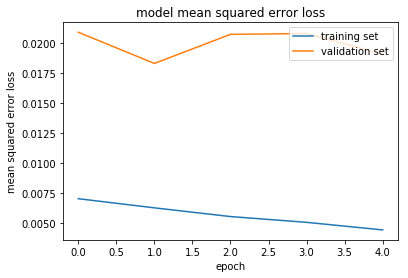

In [21]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, verbose=1)


dict_keys(['val_loss', 'loss'])


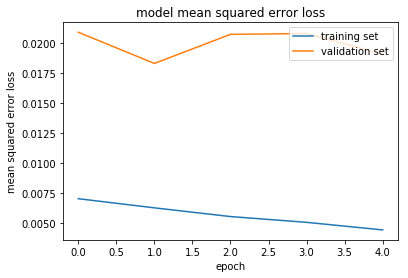

In [22]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Generators
Here is an example of how you could use a generator to load data and preprocess it on the fly, in batch size portions to feed into your Behavioral Cloning model .

In [49]:
import os
import csv

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2)

import cv2
import numpy as np
import sklearn
from random import shuffle

In [50]:
print(samples[0])
len(train_samples)
len(validation_samples)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


1608

In [57]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [58]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [61]:
ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(54,3,3,activation="relu"))
model.add(Convolution2D(54,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), validation_data=validation_generator, 
                    nb_val_samples=len(validation_samples), nb_epoch=3)

Epoch 1/3


ValueError: Error when checking model input: expected lambda_input_20 to have 4 dimensions, but got array with shape (32, 1)

In [59]:
train_generator

<generator object generator at 0x7f9b25810518>

## Recording Video in Autonomous Mode
Because your hardware setup might be different from a reviewer's hardware setup, driving behavior could be different on your machine than on the reviewer's. To help with reviewing your submission, we require that you submit a video recording of your vehicle driving autonomously around the track. The video should include at least one full lap around the track. Keep in mind the rubric specifications:

"No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle)."

In the GitHub repo, we have included a file called video.py, which can be used to create the video recording when in autonomous mode.

The README file in the GitHub repo contains instructions about how to make the video recording. Here are the instructions as well:

```python drive.py model.h5 run1```

The fourth argument, run1, is the directory in which to save the images seen by the agent. If the directory already exists, it'll be overwritten.

The image file name is a timestamp of when the image was seen.. This information is used by video.py to create a chronological video of the agent driving.
### Using video.py
```python video.py run1```

Creates a video based on images found in the run1 directory. The name of the video will be the name of the directory followed by '.mp4', so, in this case the video will be run1.mp4.

Optionally, one can specify the FPS (frames per second) of the video:

```python video.py run1 --fps 48```

The video will run at 48 FPS. The default FPS is 60.